In [1]:
import logging
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
# Function to compute and save statistics
def save_model_statistics(file_path, filters, biases, stage):
    with open(file_path, 'a') as f:
        f.write(f"\n{stage}:\n")
        for i in range(2):
            mean = np.mean(filters[:, :, 0, i])
            variance = np.var(filters[:, :, 0, i])
            f.write(f"Conv Layer {i + 1} Weights:\n")
            f.write(f"Mean: {mean}\n")
            f.write(f"Variance: {variance}\n")

            mean = np.mean(biases[i])
            variance = np.var(biases[i])
            f.write(f"Conv Layer {i + 1} Biases:\n")
            f.write(f"Mean: {mean}\n")
            f.write(f"Variance: {variance}\n")
            f.write("-" * 30 + "\n")
            f.write("-" * 30 + "\n")


In [116]:
# Function to save kernel comparison images
def save_kernel_comparison_images(file_path, filters_before, filters_after):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    for i in range(2):
        ax = axes[i, 0]
        ax.imshow(filters_before[:, :, 0, i], cmap='gray')
        ax.set_title(f'Filter {i + 1} Before Training')
        for (q, w), val in np.ndenumerate(filters_before[:, :, 0, 1]):
            ax.text(w, q, f'{val:.4f}', ha='center', va='center', color='red', fontsize=8)
        ax.axis('off')

        ax = axes[i, 1]
        ax.imshow(filters_after[:, :, 0, i], cmap='gray')
        ax.set_title(f'Filter {i + 1} After Training')
        for (x, z), val in np.ndenumerate(filters_after[:, :, 0, 1]):
            ax.text(z, x, f'{val:.4f}', ha='center', va='center', color='red', fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()


In [117]:
# Load MNIST data
mnist = keras.datasets.mnist
(x_full, y_full), (x_test_full, y_test_full) = mnist.load_data()


x_train = np.concatenate([x_full[y_full == 0][:], x_full[y_full == 1][:]])
y_train = np.concatenate([y_full[y_full == 0][:], y_full[y_full == 1][:]])
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

x_test = np.concatenate([x_test_full[y_test_full == 0][:], x_test_full[y_test_full == 1][:]])
y_test = np.concatenate([y_test_full[y_test_full == 0][:], y_test_full[y_test_full == 1][:]])
indices_test = np.arange(x_test.shape[0])
np.random.shuffle(indices_test)
x_test = x_test[indices_test]
y_test = y_test[indices_test]

print(x_full.shape)
print(y_full.shape)

# Reshape x to add a channel dimension
x_full = x_full.reshape(-1, 28, 28, 1)
x_test_full = x_test_full.reshape(-1, 28, 28, 1)

(60000, 28, 28)
(60000,)


In [118]:
# Build the CNN model
model = models.Sequential([
    layers.Conv2D(2, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(169, activation='relu'),
    layers.Dense(13, activation='relu'),
    layers.Dense(10, activation='softmax')
])


c:\Users\nandi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [119]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 2)      │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 338)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 169)            │        57,291 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 13)             │         2,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,661 (233.05 KB)

 Trainable params: 59,661 (233.05 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
weights=[]
bias=[]

for layer in model.layers:
    if 'conv' in layer.name:
        a, b = layer.get_weights()
        weights.append(a)
        bias.append(b)
        print(f"{layer.name} filters shape: {a.shape}")
        print(f"{layer.name} bias_Conv shape: {b.shape}")
        
print(weights)
print(bias)



conv2d_7 filters shape: (3, 3, 1, 2)
conv2d_7 bias_Conv shape: (2,)
[array([[[[ 1.04983538e-01,  4.37909812e-01]],

        [[-2.39225283e-01, -4.20354337e-01]],

        [[-1.41170025e-01, -2.54188418e-01]]],


       [[[ 1.08122855e-01, -2.81427771e-01]],

        [[ 3.06934118e-04,  4.50015515e-01]],

        [[ 4.55369383e-01, -2.30884939e-01]]],


       [[[-4.84361649e-02,  2.75361538e-02]],

        [[ 2.16839939e-01,  3.35630625e-01]],

        [[ 3.87146175e-02,  4.40103918e-01]]]], dtype=float32)]
[array([0., 0.], dtype=float32)]


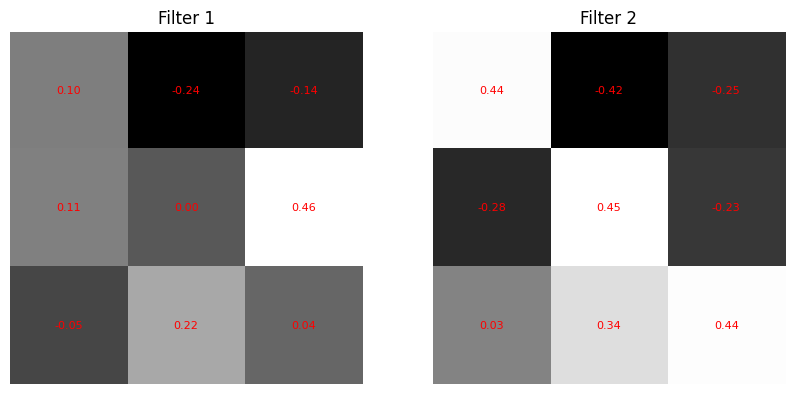

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.imshow(weights[0][:, :, 0, 0], cmap='gray')
ax.set_title('Filter 1')
ax.axis('off')
for (i, j), val in np.ndenumerate(weights[0][:, :, 0, 0]):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='red', fontsize=8)
ax = axes[1]
ax.imshow(weights[0][:, :, 0, 1], cmap='gray')
ax.set_title('Filter 2')
ax.axis('off')
for (i, j), val in np.ndenumerate(weights[0][:, :, 0, 1]):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='red', fontsize=8)
plt.show()

In [122]:
for i in range(2):
    mean = np.mean(weights[0][:, :, 0, i])
    variance = np.var(weights[0][:, :, 0, i])
    print(f"Conv Layer {i + 1} Weights:")
    print(f"Mean: {mean}")
    print(f"Variance: {variance}")
    
    mean = np.mean(bias[0][i])
    variance = np.var(bias[0][i])
    print(f"Conv Layer {i + 1} Biases:")
    print(f"Mean: {mean}")
    print(f"Variance: {variance}")
    print("-" * 30)

save_model_statistics('full_v4.txt', weights[0], bias[0], 'Before Training')

Conv Layer 1 Weights:
Mean: 0.05505619943141937
Variance: 0.0367572195827961
Conv Layer 1 Biases:
Mean: 0.0
Variance: 0.0
------------------------------
Conv Layer 2 Weights:
Mean: 0.05603783577680588
Variance: 0.11632593721151352
Conv Layer 2 Biases:
Mean: 0.0
Variance: 0.0
------------------------------


In [123]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test_full=to_categorical(y_test_full, num_classes=10)
model.fit(x_train, y_train, epochs=15)


Epoch 1/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9722 - loss: 0.4856
Epoch 2/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9982 - loss: 0.0307
Epoch 3/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9991 - loss: 0.0095
Epoch 4/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9978 - loss: 0.0233
Epoch 5/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9988 - loss: 0.0228
Epoch 6/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9995 - loss: 0.0026
Epoch 7/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9989 - loss: 0.0177
Epoch 8/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9997 - loss: 0.0023
Epoch 9/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 7.0967e-04
Epoch 10/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9974 - loss: 0.0232
Epoch 11/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 8.1785e-04
Epoch 12/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [124]:
weights_after=[]
bias_after=[]

with np.printoptions(precision=6, suppress=True):
    for layer in model.layers:
        if 'conv' in layer.name:
            a, b = layer.get_weights()
            weights_after.append(a)
            bias_after.append(b)
            print(f"{layer.name} filters shape: {a.shape}")
            print(f"{layer.name} bias_Conv shape: {b.shape}")
        



conv2d_7 filters shape: (3, 3, 1, 2)
conv2d_7 bias_Conv shape: (2,)


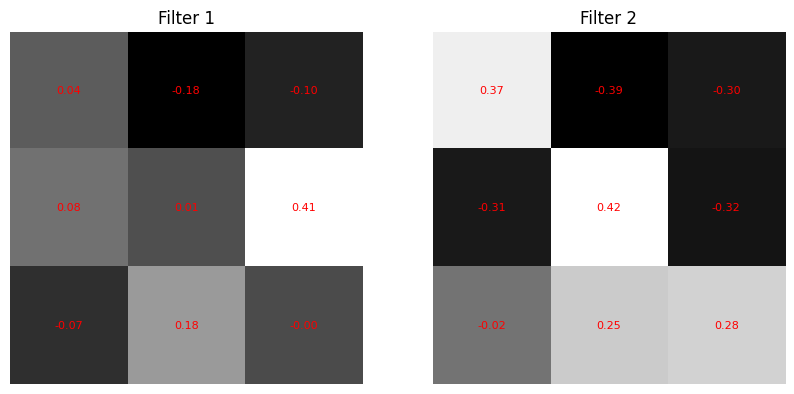

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.imshow(weights_after[0][:, :, 0, 0], cmap='gray')
ax.set_title('Filter 1')
ax.axis('off')
for (i, j), val in np.ndenumerate(weights_after[0][:, :, 0, 0]):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='red', fontsize=8)
ax = axes[1]
ax.imshow(weights_after[0][:, :, 0, 1], cmap='gray')
ax.set_title('Filter 2')
ax.axis('off')
for (i, j), val in np.ndenumerate(weights_after[0][:, :, 0, 1]):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='red', fontsize=8)
plt.show()

In [126]:
for i in range(2):
    mean = np.mean(weights_after[0][:, :, 0, i])
    variance = np.var(weights_after[0][:, :, 0, i])
    print(f"Conv Layer {i + 1} Weights:")
    print(f"Mean: {mean}")
    print(f"Variance: {variance}")
    
    mean = np.mean(bias_after[0][i])
    variance = np.var(bias_after[0][i])
    print(f"Conv Layer {i + 1} Biases:")
    print(f"Mean: {mean}")
    print(f"Variance: {variance}")
    print("-" * 30)


save_model_statistics('full_v4.txt', weights_after[0], bias_after[0], 'After Training')

Conv Layer 1 Weights:
Mean: 0.04181377589702606
Variance: 0.026482263579964638
Conv Layer 1 Biases:
Mean: -0.16281387209892273
Variance: 0.0
------------------------------
Conv Layer 2 Weights:
Mean: -0.002116858959197998
Variance: 0.09938463568687439
Conv Layer 2 Biases:
Mean: -0.21099001169204712
Variance: 0.0
------------------------------


In [127]:

# Save kernel comparison images
save_kernel_comparison_images('full_v4_kernel.png', weights[0], weights_after[0])


In [128]:
# from scipy.signal import convolve2d

# # Function to apply convolution
# def apply_convolution(image, kernel):
#     return convolve2d(image.squeeze(), kernel, mode='same', boundary='fill', fillvalue=0)

# # Apply the filters to x_short[0]
# conv_output_1 = apply_convolution(x_short[0], weights_after[0][:, :, 0, 0])
# conv_output_2 = apply_convolution(x_short[0], weights_after[0][:, :, 0, 1])

# # Plot the original image and the convolution outputs
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# # Original Image
# axes[0].imshow(x_short[0].reshape(28, 28), cmap='gray')
# axes[0].set_title('Original Image')
# axes[0].axis('on')

# # Convolution with Filter 1
# axes[1].imshow(conv_output_1, cmap='gray')
# axes[1].set_title('Convolution Output - Filter 1')
# axes[1].axis('on')

# # Convolution with Filter 2
# axes[2].imshow(conv_output_2, cmap='gray')
# axes[2].set_title('Convolution Output - Filter 2')
# axes[2].axis('on')

# plt.show()

In [129]:
test_loss, test_accuracy = model.evaluate(x_test_full, y_test_full)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

predictions = model.predict(x_test_full)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2084 - loss: 116.0458
Test Loss: 118.4192886352539
Test Accuracy: 0.21150000393390656
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [130]:
from sklearn.metrics import classification_report
y_pred = (predictions > 0.5).astype(int)  # Assuming binary classification
print(classification_report(y_test_full, y_pred))


              precision    recall  f1-score   support

           0       0.16      1.00      0.28       980
           1       0.29      1.00      0.45      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

   micro avg       0.21      0.21      0.21     10000
   macro avg       0.05      0.20      0.07     10000
weighted avg       0.05      0.21      0.08     10000
 samples avg       0.21      0.21      0.21     10000



c:\Users\nandi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
